# SPAM Classifier                                             

 ### Tess & Marceline

##### Objectif :
 - concevoir un classifieur de détection automatique de SPAM

##### Description du projet:
 - récupération des données sur le site 
"https://www.kaggle.com/uciml/sms-spam-collection-dataset"
Ce CSV contient 5 574 messages en anglais étiquetés Spam/Ham

##### Gestion du projet:
 - Mise en place le Trello pour la gestion du projet.
"https://trello.com/b/ZgS9aRbp/grpsspamclassifier"


##### Livrable:
 - On a 15 jours pour effectuer la detection automatique des SPAM.

 ##### Les étapes du projet
  * 1 - Installation des librairies
  * 2 - Ouverture du fichier spam.csv
    * 2.1 - Exploration du fichier spam
  * 3 - Nettoyage des données
    * 3.1 - Graphique barplot
  * 4 - Création des features
    * 4.1 - Description de la df 'spam1'
    * 4.2 - Graphique violinplot
  * 5 - Texte processing
    * 5.1 - Récupération des messages spam
    * 5.2 - Mise en place du stopword
    * 5.3 - Graphique barplot
    * 5.4 - Graphique wordcloud
  * 6 - Mise en place du prépocessing
    * 6.1 - Mise en place du train_test_split
  * 7 - Mise en place du du tunning (grid-search "hyperparamètres")
  * 8 - Mise en place du pipeline
  * 9 - Réalisation du modèle de machine learning
  * 10 - Résultat du machine learning avec le RandomForest
  * 11 - Graphique de la confusion de matrice
  * 12 - Prédiction

#### 1.  Installation des librairies

In [1]:
#librairie traitement du csv(dataframe)
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
import collections
from collections import OrderedDict
cmaps = OrderedDict()
import re
import string
from string import digits


#librairies graphiques
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import OrderedDict
cmaps = OrderedDict()
from wordcloud import WordCloud, STOPWORDS

#librairies machine learning
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier  
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marce\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  #### 2. Ouverture du fichier spam.csv

In [2]:
spam=pd.read_csv("https://raw.githubusercontent.com/dataIA-2021/Sms_Spam_Tess_Marceline/main/spam.csv",encoding ='ISO-8859-1')

####   2.1 Exploration du fichier spam

In [3]:
spam.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


On a pu voir que le csv contient 5 colonnes, que les noms de colonnes sont à changé et qu'il fallait supprimer les "unnamed:2,3,4"

In [4]:
spam.shape

(5572, 5)

On sait qu'il y a 5 572 lignes pour 5 colonnes

In [5]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


Description en détail de chaque colonnes ( nom, nombres de non_null, et le type)

In [6]:
spam.describe().round(2)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


 #### 3. Nettoyage des données

In [7]:
def nettoyage_data ():
#Supression des 3 dernières colonnes
    spam1=spam.drop(columns=["Unnamed: 2", "Unnamed: 3","Unnamed: 4"])
#renommer les colonnes
    spam1.columns = ['infos','messages']
    return spam1

La fonction nettoyage_data()
comprends :
   - la suppression des colonnes "unnamed:2,3,4"
   - et le remolacement des noms de colonnes (v1, v2 en 'infos' et 'messages'

#### 3.1 Graphique barplot

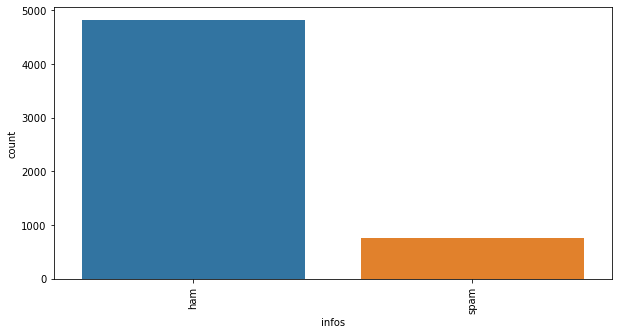

In [8]:
plt.figure(figsize=(10, 5))
sns.countplot(x="infos", data=nettoyage_data())
plt.xticks(rotation=90)
plt.show()

Sur ce graphique on peut constaté qu'il y a plus de "ham" que de "spam"

#### 4. Création des features

In [9]:
spam1=nettoyage_data()

def data_feat(spam1):
#AJOUT DE FEATURES
#colonne longueur
    spam1["longueur"] = spam1["messages"].apply(len)
    spam1=spam1.assign(ser_5_chi=0)

    for i in spam1.index:
        list_telephone_5 = re.findall(r"\d{5}", spam1["messages"][i])
        if len(list_telephone_5) >= 1:
            spam1['ser_5_chi'][i] = 1        
#Colonne spam (1,0)
    spam1["spam"] = spam1['infos'].apply(lambda x:1 if x=='spam' else 0)
    return spam1

* Nous rapelons la fonction data_feat()
* On applique la fonction len pour compter la chaine de caratères qu'il y a dans chaque ligne, le résutat on le fixe dans une nouvelle colonne "longueur".
* On créer une nouvelle colonne 'ser_5_chi'.
* Puis on créer une boucle qui va faire la rechercher sur chaques lignes la série de chiffres qui contient 5 chiffres continue et on place le résultat (booléen) dans la colonne 'ser_5_chi'.
* On ajoute une nouvelle colonne 'spam', qui indique si spam = 1 sinon ham =0.

#### 4.1 Description de la df 'spam1'

In [10]:
data_feat(spam1).groupby('infos').describe()

longueur                                                           \
         count        mean        std   min    25%    50%    75%    max   
infos                                                                     
ham     4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0   
spam     747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0   

      ser_5_chi            ...              spam                           \
          count      mean  ...  75%  max   count mean  std  min  25%  50%   
infos                      ...                                              
ham      4825.0  0.000622  ...  0.0  1.0  4825.0  0.0  0.0  0.0  0.0  0.0   
spam      747.0  0.781794  ...  1.0  1.0   747.0  1.0  0.0  1.0  1.0  1.0   

                 
       75%  max  
infos            
ham    0.0  0.0  
spam   1.0  1.0  

[2 rows x 24 columns]

#### 4.2 Graphique violinplot

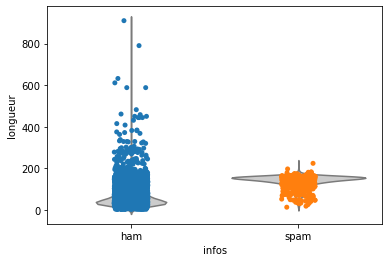

In [11]:
ax = sns.violinplot(x = spam1['infos'], y = spam1['longueur'], data=spam1, inner=None, color=".8")
ax = sns.stripplot(x = spam1['infos'], y = spam1['longueur'], data=spam1)

* On a comparer la longueur de la chaine de charactère de chaque ligne de la colonne 'longueur' par rapport a la colonne infos.
* On peut constaté que les ham on une chaîne de charactère plus longue (max:910) que les spam (max:224).

#### 5. Texte processing

#### 5.1 Récupération des messages spam

In [12]:
def data_spam(spam1):
#selection de la colonne ham et transformation en minuscule
    spam2 = spam1['messages'].loc[spam1.infos=='spam']
    spam2 = ' '.join(spam2.str.lower())
    return spam2

* Création de la fonction data_spam(spam1).
* On a récupéré les spam que l'on a placé dans une nouvelle df(spam2).
* Puis sur cette df on lui demande de mettre tout les charactères en minuscules.

#### 5.2 Mise en place du stopword

In [13]:
spam2 = data_spam(spam1)
def data_tri(spam2):
    stoplist =stopwords.words('english')
    filtered_words = [word for word in spam2.split() if word not in stoplist]
    counted_words = collections.Counter(filtered_words)    
#graphique avec le stopwords des 20 mots les plus fréquents
    words = []
    counts = []
    for letter, count in counted_words.most_common(20):
        words.append(letter)
        counts.append(count)
    return words, counts

On rappel la fonction data_spam(spam1) qu'on place dans la variable spam2.
on a créé une nouvelle fonction data_tri(spam2) dans laquelle 
- on applique un stopword qu'on nomme 'stoplist'.
- on s'épare les mot avec la fonction split() et on cherche les mots qui ne ne sont pas dans le 'stoplist'. On place le résultat dans une nouvelle variable 'filterd_words'
- On créé une nouvelle variable 'counted_word' dans l'aquelle on fait un comptages des mots d’occurrences respectifs.
- Création un dictionnaire [words], et counts []
- On créer une boucle pour qu'il rassemble et les mots en en même temps il excécute le nombre de fois qu'ils apparaissent et implémente le résultat dans les dictionnaires respectifs. 
Pour finir on lui demande de garder le top 20 mots les plus fréquents.

#### 5.3 Graphique barplot

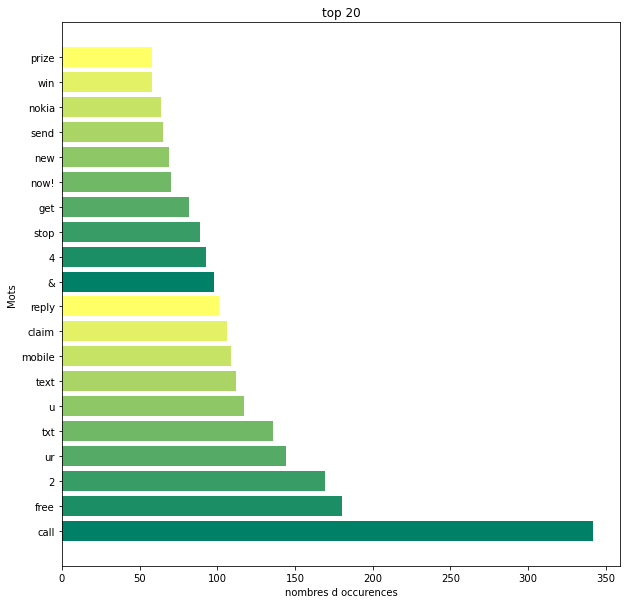

In [14]:
colors = cm.summer(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 10, 10
words, counts = data_tri(spam2)
plt.title('top 20')
plt.xlabel('nombres d occurences')
plt.ylabel('Mots')
plt.barh(words, counts, color=colors)
plt.show()

Le bar plot indiqes le top 20 des mots qui ont la plus grande occurence.

#### 5.4 Graphique wordcloud

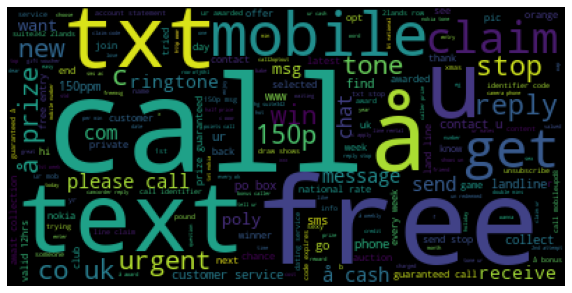

In [15]:
#graphique nuage de mots
stoplist =stopwords.words('english')
wordcloud = WordCloud(stopwords=stoplist, background_color="black", max_words=1000).generate(spam2)
rcParams['figure.figsize'] = 10, 10
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Puis avec le même résultat on a créer un wordcloud.

#### 6. Mise en place du préprocessing

In [16]:
spam4 = data_feat(spam1) 
def prepocessing(spam1):
#Extraction de texte
    spam1=spam1.assign(mot_spam=0)
    for i in spam1.index:
        list_motspam = re.compile("free|call|price|win|won|new|now|cash|text|txt|nokia")
        list_motspam_find = list_motspam.findall(spam1["messages"][i])
        if len(list_motspam_find) >= 1:
            spam1['mot_spam'][i] = 1
    X = spam1.drop(['infos','messages','spam'], axis=1)
    Y = spam1['infos']
    return X, Y

On rappel la fonction data_feat(spam1) qu'on instaure dans une variable 'spam4'.
Création de la fonction prepocessing(spam1).
 * on créé une liste de mot qui ont les plus grandes occurances, puis on fait la recherche de ses mots dans toute la colonne message de la df spam'. On lui indique que si le mot apparait tu mets 1+ et sinon 0.
 *  on lui demande de trouver les occurences des mots qui ont 1 ou suppérieur à un.
 * on défini le X (features) on lui spécifiant d'enlevé les colonnes 'infos','messages' et 'spam'.
 * on défini le Y (target) de la colonne 'infos'

#### 6.1 Mise en place du train_test_split

In [17]:
X,Y = prepocessing(spam4)
Y = label_binarize(Y, classes=['ham', 'spam'])
# Split, fit, stratify à 20%
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

#### 7. Mise en place du tunning (grid-search = "hyperparamètres")

In [18]:
#faire du tuning (recherche des hyperparamètres du classifier RandomForest)    
param_grid = {
                            'model__criterion': ["gini", "entropy"],
                            'model__n_estimators': [90, 100, 115, 130],
}
transformer_num = ColumnTransformer(transformers=[
                             ('Scaling', RobustScaler(), ['longueur'])
])     
transformer_num = None

Lise en place des hyperparamètres pour le modèle classifier RandomForest.
On met en place les parammètres grid.
Puis on effectue un scalling. 

#### 8. Mise en place du pipeline

In [19]:
pipe = Pipeline(steps=[
                             ('transformer', transformer_num),
                             ('model', RandomForestClassifier())
                             ]
                      )

#### 9. Réalisation du modèle de machine learning

In [20]:
# Déclaration de la méthode du gridsearch
grid = GridSearchCV(pipe, param_grid, scoring = 'accuracy', cv=StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123))
grid.fit(X_train, Y_train)
rf_train=grid.score(X_train, Y_train)
rf_test=grid.score(X_test, Y_test)

C:\Users\marce\anaconda3\lib\site-packages\imblearn\pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
C:\Users\marce\anaconda3\lib\site-packages\imblearn\pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
C:\Users\marce\anaconda3\lib\site-packages\imblearn\pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
C:\Users\marce\anaconda3\lib\site-packages\imblearn\pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

#### 10. Résultat du machine learning avec le RandomForest

In [21]:
print(rf_train * 100)
print(rf_test * 100)

97.35247924612969
96.41255605381166


On constate qu'avec un minimum de feature on obtient un score de :
 - 97.35% sur le train
 - 96.41% sur le test.

#### 11 Graphique de la confusion de matrice

C:\Users\marce\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


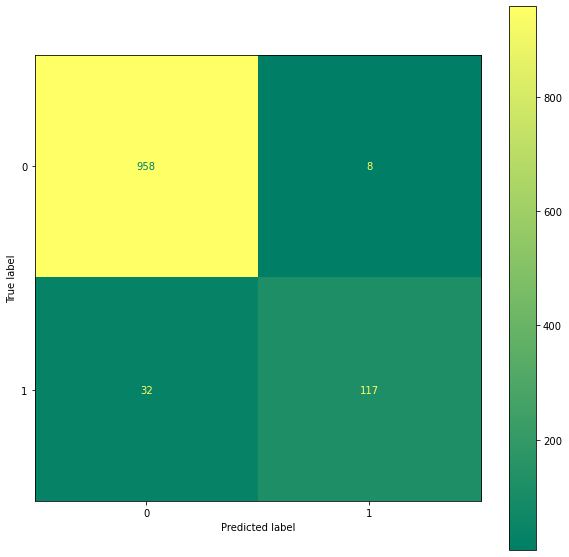

In [22]:
plot_confusion_matrix(grid, X_test, Y_test,
                      cmap=plt.cm.summer, 
                      normalize=None)

#### 12. La prédiction 

In [30]:
pred = grid.predict(X_train)


In [31]:
print(classification_report(Y_train, pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3859
           1       0.98      0.82      0.89       598

    accuracy                           0.97      4457
   macro avg       0.98      0.91      0.94      4457
weighted avg       0.97      0.97      0.97      4457

